In [ ]:
# from importlib import reload
# reload(util_data)

# Counterfactual explanation for Mobile Price Classification dataset

TODO: explain the task and something about counterfactual explanation.

## Installation and import of the needed libraries

### Installation

First of all we clone the Github repository in order to have all the needed files to perform our analysis. 

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab) 

In [1]:
# !mkdir my_repo
# !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo

Cloning into 'my_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 119 (delta 49), reused 99 (delta 29), pack-reused 0
Receiving objects: 100% (119/119), 2.57 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (49/49), done.


- OMLT, version 1.1
- ONNX, version 1.12.0. A newer version is available (1.13.1) but it gives conflict error with TensorFlow. If the latter isn't needed, then the installed version can be upgraded.

Run the following cell only if the current working directory is not the repository.

In [2]:
# %cd my_repo

/content/my_repo


Then we can install all the libraries from the ```requirements.txt``` file.

In [3]:
# !pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 769.3 kB/s eta 0:00:00


### Import

In [7]:
# python modules
import configparser
import math
import re

# 3rd party modules
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# user modules
from utils import util_data, util_plot, util_network

kaggle error. Some functions will not work.


In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

In [8]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng

SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.

In [9]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

## Dataset exploration

In [10]:
ds_conf = config["GSMARENA_DS"]
# Download the training and test datasets
dh = util_data.DownloadHelper(ds_conf["url"], ds_conf["name"], ds_conf["mode"], quiet=False)

dh.download()

File gsm.csv already exists. Skip download.


In [11]:
df_raw = dh.read_csv()

/content/my_repo/utils/util_data.py:67: DtypeWarning: Columns (66,67,71,76,78,82) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.file_path, **kwargs)


### Preliminary exploration

In [12]:
df_raw.head(3)

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
0,Benefon,Vega,GSM,GSM 900,No,No,1999,Discontinued,145 x 56 x 23 mm (5.71 x 2.20 x 0.91 in),190 g (6.70 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,4 - 10 h,3 - 6 days
1,Garmin-Asus,nuvifone M10,GSM / HSPA,GSM 900 / 1800 / 1900,NaN,NaN,"2010, January. Released 2010, March",Discontinued,-,-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,GSM 850 / 1800 / 1900 - US version,Up to 8 h,Up to 600 h (2G) / Up to 600 h (3G)
2,Gigabyte,GSmart G1305 Boston,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2010, April. Released 2010, April",Discontinued,116 x 56.8 x 12.4 mm (4.57 x 2.24 x 0.49 in),118 g (4.16 oz),...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,Up to 7 h 10 min,Up to 410 h


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10679 entries, 0 to 10678
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   oem                         10679 non-null  object
 1   model                       10679 non-null  object
 2   network_technology          10679 non-null  object
 3   network_2g_bands            10355 non-null  object
 4   network_gprs                9714 non-null   object
 5   network_edge                9720 non-null   object
 6   launch_announced            10679 non-null  object
 7   launch_status               10679 non-null  object
 8   body_dimensions             10679 non-null  object
 9   body_weight                 10587 non-null  object
 10  body_sim                    10678 non-null  object
 11  display_type                10679 non-null  object
 12  display_size                9287 non-null   object
 13  display_resolution          10630 non-null  ob

In [ ]:
print(f"Number of rows: {df_raw.shape[0]}")

Number of rows: 10679


In [ ]:
print(df_raw.columns)

Index(['oem', 'model', 'network_technology', 'network_2g_bands',
       'network_gprs', 'network_edge', 'launch_announced', 'launch_status',
       'body_dimensions', 'body_weight', 'body_sim', 'display_type',
       'display_size', 'display_resolution', 'display', 'memory_card_slot',
       'memory_phonebook', 'memory_call_records', 'sound_loudspeaker',
       'sound_alert_types', 'sound_3.5mm_jack', 'comms_wlan',
       'comms_bluetooth', 'comms_gps', 'comms_radio', 'comms_usb',
       'features_sensors', 'features_messaging', 'features_browser',
       'features_clock', 'features_alarm', 'features_games', 'features_java',
       'features', 'misc_colors', 'network_3g_bands', 'network_speed',
       'platform_os', 'platform_chipset', 'platform_cpu', 'platform_gpu',
       'memory_internal', 'main_camera_single', 'main_camera_video',
       'misc_price', 'main_camera_features', 'body', 'network_4g_bands',
       'body_build', 'display_protection', 'memory', 'main_camera_dual',
       

### Explore the misc_price column

In [13]:
df_raw = df_raw[df_raw.misc_price.notna()].reset_index(drop=True)
print(f"Number of rows: {df_raw.shape[0]}")

Number of rows: 6537


In [14]:
def extract_replace(pattern: str, df: pd.DataFrame, col: str, mode: str):
    # extract the pattern
    extract_col = df[col].str.extract(pattern, expand=False, flags=re.IGNORECASE).dropna()
    # replace comma with none
    if mode == "price":
        extract_col = extract_col.str.replace(",", "")
    elif mode == "string":
        extract_col = extract_col.str.upper()

    # print the number of rows
    print(f"Extracted {extract_col.shape[0]} rows in {col}")

    df.loc[extract_col.index, col] = extract_col
    return df, extract_col.index

In [15]:
# create an empty Index object
all_ext_idx = pd.Index([])

Transform EUR prices

In [16]:
df_raw, ext_idx = extract_replace("([\d]{2,4}) EUR", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 6044 rows in misc_price


Transform USD prices

In [17]:
df_raw, ext_idx = extract_replace("([\d]{2,4}) USD", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 71 rows in misc_price


Transform INR prices. These prices are ignored.

In [ ]:
# df_raw = extract_replace("([\d]{4,5}) INR", df_raw, "misc_price")

Trasform HTML tag EUR prices

In [18]:
idx = 2
print(f"Price before parse: {df_raw.loc[idx].misc_price}")

tag_parse = df_raw.misc_price.str.replace("<e2><82><ac>", "EUR", regex=False).str.replace("<e2><80><89>", " ", regex=False)
df_raw.misc_price = tag_parse

print(f"Price after parse: {df_raw.loc[idx].misc_price}")

Price before parse: <c2><a3><e2><80><89>679.00 / <e2><82><ac><e2><80><89>599.00 / $<e2><80><89>479.99
Price after parse: <c2><a3> 679.00 / EUR 599.00 / $ 479.99


In [19]:
df_raw, ext_idx = extract_replace("EUR ([\d]{0,1}[,]{0,1}[\d]{2,3}\.[\d]{2})", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 202 rows in misc_price


Trasform HTML tag USD prices

In [20]:
df_raw, ext_idx = extract_replace("\$ ([\d]{0,1}[,]{0,1}[\d]{2,3}\.[\d]{2})", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 105 rows in misc_price


Trasform HTML tag POUND prices

In [21]:
idx = 21
# print the price before the parse
print(f"Price before parse: {df_raw.loc[idx].misc_price}")
# parse the html tag to the currency
tag_parse = df_raw.misc_price.str.replace("<c2><a3>", "POUND")
df_raw.misc_price = tag_parse
# print the price after parse
print(f"Price after parse: {df_raw.loc[idx].misc_price}")

Price before parse: <c2><a3> 129.99
Price after parse: POUND 129.99


In [22]:
df_raw, ext_idx = extract_replace("POUND ([\d]{0,1}[,]{0,1}[\d]{2,3}\.[\d]{2})", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 12 rows in misc_price


Trasform HTML tag INR prices. These prices are ignored.

In [ ]:
# print(f"Price before parse: {df_lastN.loc[226].misc_price}")

# tag_parse = df_lastN.loc[idx_hold].misc_price.str.replace("<e2><82><b9>", "INR")
# df_lastN.misc_price = tag_parse

# print(f"Price after parse: {df_lastN.loc[226].misc_price}")

In [ ]:
# df_raw = extract_replace("INR ([\d]{0,2}[,][\d]{3})", df_raw, "misc_price")

Transform EUR prices

In [23]:
idx = 829
print(f"Price before parse: {df_raw.loc[829].misc_price}")

tag_parse = df_raw.misc_price.str.replace("\u2009", " ")
df_raw.misc_price = tag_parse

print(f"Price after parse: {df_raw.loc[829].misc_price}")

Price before parse: € 149.99 / £ 99.99
Price after parse: € 149.99 / £ 99.99


In [24]:
df_raw, ext_idx = extract_replace("€ ([\d]{0,1}[,]{0,1}[\d]{2,3}\.[\d]{2})", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 3 rows in misc_price


Transform USD prices

In [25]:
df_raw, ext_idx = extract_replace("\$ ([\d]{0,1}[,]{0,1}[\d]{2,3}\.[\d]{2})", df_raw, "misc_price", mode="price")
all_ext_idx = all_ext_idx.union(ext_idx)

Extracted 1 rows in misc_price


Keep only parsed rows

In [26]:
# limit df_raw by only indexes in all_ext_idx
df_raw = df_raw.loc[all_ext_idx].reset_index(drop=True).astype({"misc_price": float})
print(f"Number of rows: {df_raw.shape[0]}")

Number of rows: 6438


### Remove duplicates

In [27]:
df_raw = df_raw.drop_duplicates()

### Explore year distribution

In [ ]:
# def extract_replace_num(pattern: str, df: pd.DataFrame, col: str):
#     # extract the pattern
#     extract_col = df[col].str.extract(pattern, expand=False).dropna()
#     # print the number of rows
#     print(f"Extracted {extract_col.shape[0]} rows in {col}")

#     df.loc[extract_col.index, col] = extract_col
#     return df, extract_col.index

In [28]:
df_raw, ext_idx = extract_replace("([\d]{4})", df_raw, "launch_announced", mode="num")
df_raw = df_raw.loc[ext_idx].reset_index(drop=True).astype({"launch_announced": int})

Extracted 6159 rows in launch_announced


In [29]:
year_counts = df_raw.launch_announced.value_counts().sort_index()

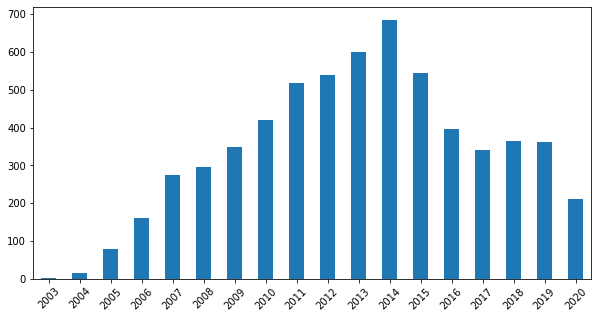

In [30]:
year_counts.plot(kind="bar", rot=45, figsize=(10, 5))
plt.show()

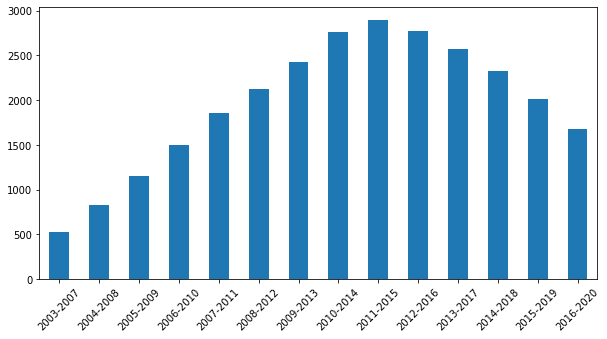

In [31]:
N = 5
names = list()
for i in range(N-1, len(year_counts)):
    names.append(f"{year_counts.index[i-N+1]}-{year_counts.index[i]}")

windows_counts = year_counts.rolling(window=N).sum().dropna().astype(int)
windows_counts.index = names

windows_counts.plot(kind="bar", rot=45, figsize=(10, 5))
plt.show()

In [ ]:
windows_counts

2003-2007     529
2004-2008     824
2005-2009    1158
2006-2010    1500
2007-2011    1859
2008-2012    2125
2009-2013    2429
2010-2014    2766
2011-2015    2890
2012-2016    2767
2013-2017    2567
2014-2018    2330
2015-2019    2008
2016-2020    1674
Name: launch_announced, dtype: int32

In [ ]:
df_raw.misc_price.describe()

count    6159.000000
mean      203.951208
std       313.939100
min        10.000000
25%        90.000000
50%       150.000000
75%       250.000000
max      9000.000000
Name: misc_price, dtype: float64

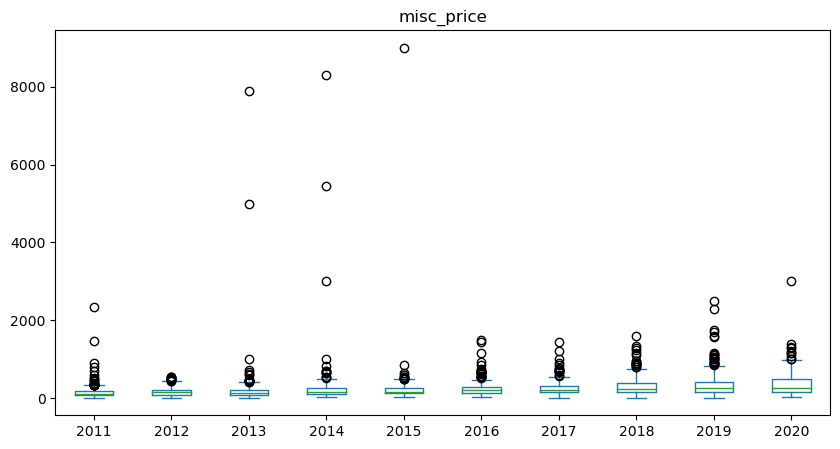

In [ ]:
# show boxplot of misc_price for distinct launch_announced
df_raw[df_raw.launch_announced > 2010].plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()

### Relevant features

Relevant features
- body_dimensions
- body_weight
- body_sim
- display_type
- display_size
- display_resolution
- memory_card_slot
- sound_loudspeaker
- sound_3.5mm_jack
- comms_wlan
- comms_bluetooth
- comms_gps
- comms_nfc
- memory_internal
- main_camera_single
- misc_price
- network_4g_bands
- selfie_camera_single
- network_5g_bands
- battery
- platform_cpu

Prices distribution in the last N years

In [319]:
last_year = 2020
df_lastN = df_raw[(df_raw.launch_announced > 2020 - N) & (df_raw.launch_announced <= 2020)].reset_index(drop=True)
print(f"Number of rows: {df_lastN.shape[0]}")

Number of rows: 1674


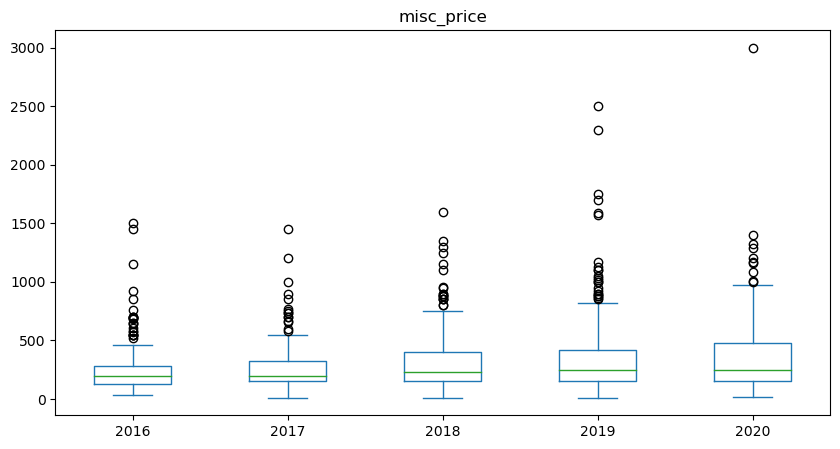

In [ ]:
# show boxplot of misc_price for distinct launch_announced
df_lastN.plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()

Comparison between iPhone models

In [ ]:
def find_model(name, df):
    df_res = df[df.model.str.contains(name, case=False)][["model", "misc_price"]]
    # concatenate columns for each rows
    str_res = df_res.apply(lambda x: f"{x.model} - {x.misc_price}", axis=1)
    # concatenate a series along rows
    return str_res.str.cat(sep=" | ")

for i in range(2020 - N + 1, 2020 + 1):
    print(f"{i}: {find_model('Iphone', df_lastN[df_lastN.launch_announced == i])}")

2016: iPhone 7 Plus - 690.0 | iPhone 7 - 550.0 | iPhone SE - 300.0
2017: iPhone X - 1000.0 | iPhone 8 Plus - 770.0 | iPhone 8 - 700.0
2018: iPhone XS Max - 1250.0 | iPhone XS - 1150.0 | iPhone XR - 850.0
2019: iPhone 11 Pro Max - 1124.0 | iPhone 11 Pro - 1029.0 | iPhone 11 - 729.0
2020: iPhone SE (2020) - 479.0


Display size

In [320]:
df_lastN , ext_idx = extract_replace("([\d]{1,2}\.[\d]{1,2}) inches", df_lastN, "display_size", mode="num")

df_lastN = df_lastN.loc[ext_idx].reset_index(drop=True).astype({"display_size": float})

Extracted 1674 rows in display_size


Remove rows with display_size greater than 7.5 inches or lower than 4 inches

In [321]:
df_lastN = df_lastN[(df_lastN.display_size <= 7.5) & (df_lastN.display_size >= 4)].reset_index(drop=True)

print(f"Number of rows: {df_lastN.shape[0]}")

Number of rows: 1495


Body sim

TODO: remove the feature or understand how to split in different categorical values.

In [ ]:
df_lastN[df_lastN.body_sim == "No"]

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
399,Allview,Viva C703,No cellular connectivity,NaN,No,No,2019,"Available. Released 2019, October",188.5 x 108.3 x 9.7 mm (7.42 x 4.26 x 0.38 in),242 g (8.54 oz),...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN
450,alcatel,1T 7,No cellular connectivity,NaN,No,Yes,2018,"Available. Released 2018, June",189.5 x 111 x 9.2 mm (7.46 x 4.37 x 0.36 in),245 g (8.64 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,Amazon,Fire 7 (2017),No cellular connectivity,NaN,No,No,2017,"Available. Released 2017, June",192 x 115 x 9.6 mm (7.56 x 4.53 x 0.38 in),295 g (10.41 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up to 8 h,NaN
790,Huawei,MediaPad T3 7.0,No cellular connectivity,NaN,No,No,2017,"Available. Released 2017, May",179 x 103.7 x 8.6 mm (7.05 x 4.08 x 0.34 in),250 g (8.82 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,Lenovo,Tab 7 Essential,No cellular connectivity,NaN,No,No,2017,"Available. Released 2017, November",194.8 x 102 x 8.8 mm (7.67 x 4.02 x 0.35 in),254 g (8.96 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
847,Lenovo,Tab 7,No cellular connectivity,NaN,No,No,2017,"Available. Released 2017, November",193 x 98.7 x 8.4 mm (7.60 x 3.89 x 0.33 in),260 g (9.17 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_lastN[~df_lastN.body_sim.str.contains("dual", case=False)].body_sim.value_counts().index.to_list()

['Nano-SIM',
 'Micro-SIM',
 'Nano-SIM card & eSIM',
 'No',
 'Pre-installed Nano-SIM',
 'Nano-SIM, eSIM',
 'eSIM',
 'Nano-SIM and/or eSIM',
 'Nano-SIM, Electronic SIM card (eSIM)',
 'Single SIM (Nano-SIM)',
 'Triple SIM (Nano-SIM, triple stand-by)']

In [ ]:
df_lastN.body_sim.value_counts().index.to_list()

['Dual SIM (Nano-SIM, dual stand-by)',
 'Hybrid Dual SIM (Nano-SIM, dual stand-by)',
 'Single SIM (Nano-SIM) or Dual SIM (Nano-SIM, dual stand-by)',
 'Single SIM (Nano-SIM) or Hybrid Dual SIM (Nano-SIM, dual stand-by)',
 'Nano-SIM',
 'Dual SIM (Micro-SIM, dual stand-by)',
 'Dual SIM',
 'Hybrid Dual SIM (Micro-SIM/Nano-SIM, dual stand-by)',
 'Single SIM (Micro-SIM) or Dual SIM (Micro-SIM, dual stand-by)',
 'Hybrid Dual SIM (Nano-SIM/ Micro-SIM, dual stand-by)',
 'Micro-SIM',
 'Dual SIM (Micro-SIM/Nano-SIM, dual stand-by)',
 'Hybrid Dual SIM',
 'Hybrid Dual SIM (Micro-SIM, dual stand-by)',
 'No',
 'Nano-SIM card & eSIM',
 'Single SIM (Nano-SIM and/or eSIM) or Hybrid Dual SIM (Nano-SIM, dual stand-by)',
 'Dual SIM (Micro-SIM)',
 'Dual SIM (Nano-SIM/Micro-SIM, dual stand-by)',
 'Pre-installed Nano-SIM',
 'Single SIM (Micro-SIM) or Hybrid Dual SIM (Micro-SIM, dual stand-by)',
 'Single SIM (Nano-SIM) or Dual SIM (Nano-SIM, dual stand-by) - for China',
 'Dual SIM (Nano-SIM/ Micro-SIM, dual st

Body weight

In [322]:
df_lastN, ext_idx = extract_replace("([\d]{2,3}) g", df_lastN, "body_weight", mode="num")
df_lastN = df_lastN.loc[ext_idx].reset_index(drop=True).astype({"body_weight": int})

Extracted 1290 rows in body_weight


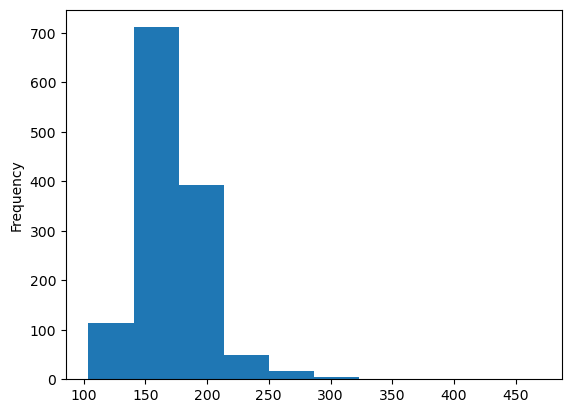

In [ ]:
df_lastN.body_weight.plot.hist(bins=10)
plt.show()

Display type

In [ ]:
df_lastN[df_lastN.display_type.isna()]

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by


In [323]:
df_lastN, ext_idx = extract_replace("(oled)", df_lastN, "display_type", mode="string")

Extracted 350 rows in display_type


In [324]:
df_lastN.loc[df_lastN.index.difference(ext_idx), "display_type"] = "LCD"

In [ ]:
df_lastN.display_type.unique()

array(['OLED', 'LCD'], dtype=object)

Display resolution

In [325]:
df_ext = df_lastN.display_resolution.str.extract("^([\d]{3,4}) x ([\d]{3,4}).*?([\d]{1,2}:[\d]{1,2}) ratio", flags=re.IGNORECASE).dropna()\
    .rename(columns={0: "px_width", 1: "px_height", 2: "display_ratio"})\
    .astype({"px_width": int, "px_height": int, "display_ratio": str})

df_lastN = pd.concat([df_lastN, df_ext], axis=1).drop(columns="display_resolution")

<Axes: xlabel='px_width', ylabel='px_height'>

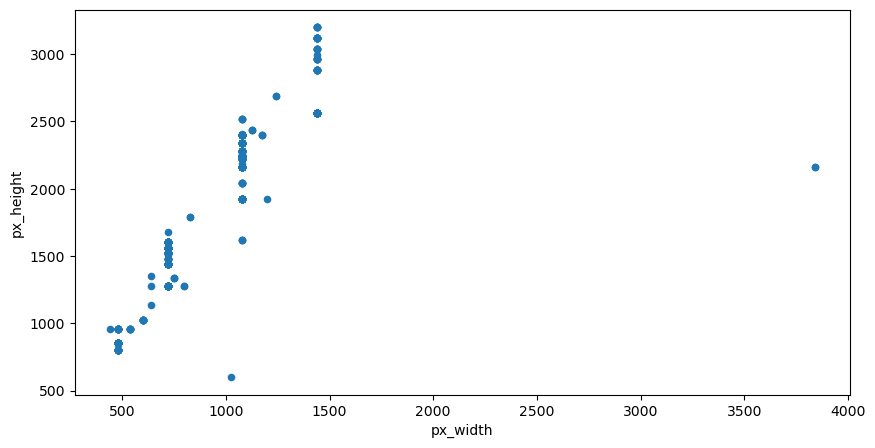

In [ ]:
df_lastN.plot(kind="scatter", x="px_width", y="px_height", figsize=(10, 5))

In [ ]:
df_lastN[["px_width", "px_height"]].value_counts()

px_width  px_height
1080.0    1920.0       227
720.0     1280.0       220
1080.0    2340.0       156
          2160.0        83
720.0     1440.0        80
1080.0    2400.0        73
720.0     1520.0        58
1440.0    2560.0        49
1080.0    2280.0        33
720.0     1560.0        31
480.0     854.0         31
720.0     1600.0        23
480.0     800.0         16
1080.0    2246.0        14
1440.0    3120.0        13
480.0     960.0         12
1080.0    2220.0        10
1440.0    2880.0        10
600.0     1024.0         9
1440.0    2960.0         7
720.0     1480.0         7
1080.0    2244.0         7
540.0     960.0          7
1080.0    2040.0         6
1440.0    3040.0         6
          3200.0         6
1080.0    2232.0         4
          2520.0         4
750.0     1334.0         3
1176.0    2400.0         3
1080.0    1620.0         3
720.0     1512.0         3
1125.0    2436.0         3
1242.0    2688.0         2
3840.0    2160.0         2
1080.0    2270.0         2
        

Memory card slot

In [ ]:
df_lastN[df_lastN.memory_card_slot.isna()]

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by,px_width,px_height,display_ratio


In [326]:
df_lastN, ext_idx = extract_replace("^(no)$", df_lastN, "memory_card_slot", mode="string")

Extracted 211 rows in memory_card_slot


In [327]:
df_lastN.loc[df_lastN.index.difference(ext_idx), "memory_card_slot"] = "YES"

In [ ]:
df_lastN.memory_card_slot.unique()

array(['NO', 'YES'], dtype=object)

Sound loudspeaker

In [ ]:
df_lastN[df_lastN.sound_loudspeaker.isna()]

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by,px_width,px_height,display_ratio


In [328]:
df_lastN, ext_idx = extract_replace("^(Yes)$", df_lastN, "sound_loudspeaker", mode="string")
df_lastN.loc[ext_idx, "sound_loudspeaker"] = "Mono"
df_lastN.loc[df_lastN.index.difference(ext_idx), "sound_loudspeaker"] = "Stereo"

Extracted 1100 rows in sound_loudspeaker


Sound 3.5mm jack

In [ ]:
df_lastN["sound_3.5mm_jack"].unique()

array(['No', 'Yes'], dtype=object)

comms_wlan

In [ ]:
df_lastN[df_lastN.comms_wlan.isna()]

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by,px_width,px_height,display_ratio


In [329]:
df_lastN, ext_idx = extract_replace("([^/]b/g/n[^/])", df_lastN, "comms_wlan", mode="string")
df_lastN.loc[ext_idx, "comms_wlan"] = "Mono"
df_lastN.loc[df_lastN.index.difference(ext_idx), "comms_wlan"] = "Dual"

Extracted 515 rows in comms_wlan


NFC

In [ ]:
print(f"NAN in comms_nfc: {df_lastN.comms_nfc.isna().sum()}")

NAN in comms_nfc: 746


In [330]:
df_lastN.comms_nfc = df_lastN.comms_nfc.fillna("No")

In [331]:
df_lastN, ext_idx = extract_replace("(no)", df_lastN, "comms_nfc", mode="string")
df_lastN.loc[ext_idx, "comms_nfc"] = "NO"
df_lastN.loc[df_lastN.index.difference(ext_idx), "comms_nfc"] = "YES"

Extracted 751 rows in comms_nfc


Memory internal

In [ ]:
df_lastN.memory_internal.isna().sum()

0

In [332]:
df_ext = df_lastN.memory_internal.str.extract("^([\d]{1,3})(?:/[\d]+)*[\s]*GB[,]?[\s]?([\d]{1,3})", flags=re.IGNORECASE).dropna()\
    .rename(columns={0: "gb_rom", 1: "gb_ram"})\
    .astype({"gb_rom": int, "gb_ram": int})

df_lastN = pd.concat([df_lastN, df_ext], axis=1).drop(columns="memory_internal")

In [ ]:
df_lastN.gb_ram.value_counts().index.to_list()

[4.0, 3.0, 6.0, 2.0, 8.0, 1.0, 12.0, 0.5, 10.0]

In [333]:
anomaly_idx = df_lastN.gb_ram > 500
df_lastN.loc[anomaly_idx, "gb_ram"] = df_lastN.loc[anomaly_idx, "gb_ram"] / 1024

***Main Camera Single***

TODO: from the starting set of features we need to remove main_camera_video, main_camera_features, main_camera, main_camera_v1, selfie_camera_video, selfie_camera_features.

In this case we have 6 different features that contain the data of the main camera of the different devices. The strings are different therefore we need different regex in order to deal with all the data.

In [334]:
# Drop the device without cellular activity and camera information
idx_useless_dev = df_lastN[df_lastN.main_camera_v1.notna()].index
df_lastN = df_lastN.drop(idx_useless_dev)

In [335]:
def extract_camera_info(df, cols, regex, mode='main', new_col="main_camera_res"):
    num_camera = "n_main_cam" if mode=="main" else "n_selfie_cam"
    df[new_col] = -1
    for (i, col) in enumerate(cols):
        camera_mp = df[col].str.extract(regex, expand=False)
        not_na = camera_mp.notna()
        # Insert the values in the right rows
        df.loc[camera_mp[not_na].index, new_col] = camera_mp[not_na]
        # We pass as last column the devices with 2/3 cameras and we set to 2
        if i == len(cols)-1 and mode=='main':
            df.loc[camera_mp[not_na].index, num_camera] = 2
        else:    
            df.loc[camera_mp[not_na].index, num_camera] = i+1
        df[new_col] = df[new_col].astype(int)
        # Drop the old feature
        df = df.drop(col, axis=1)
    # Change the last 2 values that have 'V1' as camera info
    df.loc[df[new_col] == -1, new_col] = 10
    return df

The 'alcatel' 3x model and the LG K8 model have the 'V1' value instead of a sensible string, we think V1 corresponds to 10 MP.

In [336]:
main_camera_feat = ['main_camera_single', 'main_camera_dual', 'main_camera_triple',
               'main_camera_quad', 'main_camera_five', 'main_camera_dual_or_triple']
reg_main_camera = "^([\d]{1,3})\sMP"

df_lastN = extract_camera_info(df_lastN, main_camera_feat, reg_main_camera)

In [337]:
df_lastN

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,network,battery_talk_time,battery_stand.by,px_width,px_height,display_ratio,gb_rom,gb_ram,main_camera_res,n_main_cam
0,Google,Pixel 4 XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, October 22",160.4 x 75.1 x 8.2 mm (6.31 x 2.96 x 0.32 in),193,...,CDMA 800 / 1900,NaN,NaN,1440.0,3040.0,19:9,64.0,6.0,10,NaN
1,Google,Pixel 4,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, October 22",147.1 x 68.8 x 8.2 mm (5.79 x 2.71 x 0.32 in),162,...,CDMA 800 / 1900,NaN,NaN,1080.0,2280.0,19:9,64.0,6.0,10,NaN
2,Google,Pixel 3a XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, May 15",160.1 x 76.1 x 8.2 mm (6.30 x 3.00 x 0.32 in),167,...,CDMA 800 / 1900,NaN,NaN,1080.0,2160.0,18:9,64.0,4.0,10,NaN
3,Google,Pixel 3a,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, May 15",151.3 x 70.1 x 8.2 mm (5.96 x 2.76 x 0.32 in),147,...,CDMA 800 / 1900,NaN,NaN,1080.0,2220.0,5:9,64.0,4.0,10,NaN
4,Honor,8S 2020,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (D...,NaN,NaN,2020,"Available. Released 2020, May 27",147.1 x 70.8 x 8.5 mm (5.79 x 2.79 x 0.33 in),146,...,NaN,NaN,NaN,720.0,1520.0,19:9,64.0,3.0,13,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,ZTE,Blade V Plus,GSM / HSPA / LTE,GSM 900 / 1800 - SIM 1 & SIM 2,Yes,Yes,2016,"Available. Released 2016, February",155.3 x 77.2 x 8.6 mm (6.11 x 3.04 x 0.34 in),164,...,"LTE band 1(2100), 3(1800), 7(2600), 38(2600), ...",Up to 9 h,Up to 220 h,1080.0,1920.0,16:9,16.0,2.0,13,1.0
1286,ZTE,Blade A512,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,Yes,2016,"Available. Released 2016, July",164.3 x 71.6 x 7.6 mm (6.47 x 2.82 x 0.30 in),130,...,NaN,NaN,NaN,720.0,1280.0,16:9,16.0,2.0,13,1.0
1287,ZTE,Blade A2,GSM / CDMA / HSPA / CDMA2000 / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,Yes,2016,"Available. Released 2016, June",143.8 x 70.2 x 7.9 mm (5.66 x 2.76 x 0.31 in),135,...,CDMA2000 1x,NaN,NaN,720.0,1280.0,16:9,16.0,2.0,13,1.0
1288,ZTE,Blade A910,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,Yes,2016,"Available. Released 2016, April",154 x 79 x 6.9 mm (6.06 x 3.11 x 0.27 in),135,...,"LTE band 1(2100), 3(1800), 5(850), 7(2600), 8(...",NaN,NaN,720.0,1280.0,16:9,16.0,2.0,13,1.0


Considering the selfie cameras we need to remove some samples for which we don't have information about the MP.

In [338]:
df_lastN[df_lastN.selfie_camera.notna()].selfie_camera

423                       Yes
1129    No - uses main camera
1242    No - uses main camera
1253                       No
Name: selfie_camera, dtype: object

In [339]:
df_lastN = df_lastN.drop([423,1129, 1242, 1253])

Then we repeat the procedure used for the main camera, we call the same function and we extract the information about the MP and we create a feature to count how many cameras the device has.

In [340]:
selfie_camera_feat = ['selfie_camera_single', 'selfie_camera_dual', 'selfie_camera_triple']
reg_selfie_camera = "([\d]{1,3})\sMP"

df_lastN = extract_camera_info(df_lastN, selfie_camera_feat, reg_selfie_camera, 
                               mode="selfie", new_col="selfie_camera_res")

***network_4g_bands***

TODO: how to write a regex that first looks for a word and if it doesn't find it, it looks for the other of the OR?
e.g. using (5G|LTE) it will return LTE if it appears before 5G, but we would like to first search for 5G.

In [ ]:
df_lastN.network_4g_bands.value_counts().index.to_list()

In [ ]:
relevant_features = ["body_weight", "body_sim", "display_type", "display_size", "display_resolution", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "comms_nfc", "memory_internal", "main_camera_single", "misc_price", "network_4g_bands", "selfie_camera_single", "network_5g_bands", "battery", "platform_cpu"]

***Battery***

In [341]:
print(f"There are {df_lastN.battery.isna().sum()} Nan values for the battery that will be dropped")

There are 2 Nan values for the battery that will be dropped


In [342]:
df_bat = df_lastN.battery.str.extract("^([\d]{4,5})\s mAh", flags=re.IGNORECASE).dropna()\
            .rename(columns={0: "battery"})\
            .astype(int)

df_lastN = pd.concat([df_lastN.drop("battery", axis=1), df_bat], axis=1)

### Other features

Irrelevant features
- oem
- model
- network_2g_bands
- network_gprs
- network_edge
- launch_status
- display
- memory_phonebook
- memory_call_records
- sound_alert_types
- comms_radio
- features_messaging
- features_browser
- features_clock
- features_alarm
- features_games
- features_java
- features
- misc_colors
- network_3g_bands
- network_speed
- misc_models
- tests_camera
- tests_loudspeaker
- tests_audio_quality
- tests_display
- misc_sar_eu
- features_languages
- body_keyboard
- misc_sar
- main_camera
- network

TODO features
- network_technology: extract only 4G/5G knowledge
- launch_announced
- comms_usb
- features_sensors
- platform_os
- platform_chipset
- platform_gpu
- main_camera_video
- main_camera_features
- body
- body_build
- display_protection
- memory
- main_camera_dual
- selfie_camera_dual
- selfie_camera_features
- selfie_camera_video
- battery_charging
- tests_performance: FOR RANKING PURPOSE
- tests_battery_life
- comms_infrared_port
- main_camera_quad
- main_camera_triple
- sound
- main_camera_five
- main_camera_dual_or_triple
- battery_music_play
- selfie_camera_triple
- main_camera_v1
- selfie_camera
- camera
- battery_talk_time
- battery_stand.by

In [ ]:
tmp_df = df_raw[df_raw.features_games.notna()]
tmp_df[~tmp_df.features_games.str.contains("Yes")].iloc[1].features_games

'Downloadable'

In [ ]:
print(f"Number of null entries: {df_raw.isnull().sum().sum()}")

Number of null entries: 483506


In [ ]:
features_cols = df_raw.columns[df_raw.columns != "price_range"]

# consider only rows which have the same feature values 
df_raw[df_raw.duplicated(subset=features_cols, keep=False)].copy()

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
0,Benefon,Vega,GSM,GSM 900,No,No,1999,Discontinued,145 x 56 x 23 mm (5.71 x 2.20 x 0.91 in),190 g (6.70 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,4 - 10 h,3 - 6 days
1,Garmin-Asus,nuvifone M10,GSM / HSPA,GSM 900 / 1800 / 1900,NaN,NaN,"2010, January. Released 2010, March",Discontinued,-,-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,GSM 850 / 1800 / 1900 - US version,Up to 8 h,Up to 600 h (2G) / Up to 600 h (3G)
2,Gigabyte,GSmart G1305 Boston,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2010, April. Released 2010, April",Discontinued,116 x 56.8 x 12.4 mm (4.57 x 2.24 x 0.49 in),118 g (4.16 oz),...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,Up to 7 h 10 min,Up to 410 h
3,Gigabyte,GSmart,GSM / HSPA,GSM 900 / 1800,NaN,NaN,Not officially announced yet,Cancelled,103 x 54 x 13.4 mm (4.06 x 2.13 x 0.53 in),-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,NaN,NaN
4,Google,Pixel 4 XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2019, October 15","Available. Released 2019, October 22",160.4 x 75.1 x 8.2 mm (6.31 x 2.96 x 0.32 in),193 g (6.81 oz),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDMA 800 / 1900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,Sagem,MC 850,GSM,GSM 900 / 1800,No,No,1998,Discontinued,132 x 50 x 21 mm (5.20 x 1.97 x 0.83 in),137 g (4.83 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,5 h,140 h
1453,Sagem,MC 825 FM,GSM,GSM 900 / 1800,No,No,1998,Discontinued,132 x 50 x 26 mm (5.20 x 1.97 x 1.02 in),152 g (5.36 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,3 h,90 h
1454,Sagem,MC 820,GSM,GSM 900 / 1800,No,No,1998,Discontinued,130 x 50 x 26 mm (5.12 x 1.97 x 1.02 in),135 g (4.76 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,3 h,90 h
1455,Sagem,RC 750,GSM,GSM 900,No,No,1998,Discontinued,140 x 50 x 21 mm (5.51 x 1.97 x 0.83 in),158 g (5.57 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,150 min,80 h


### Plot of feature distributions

NameError: name 'xticks' is not defined

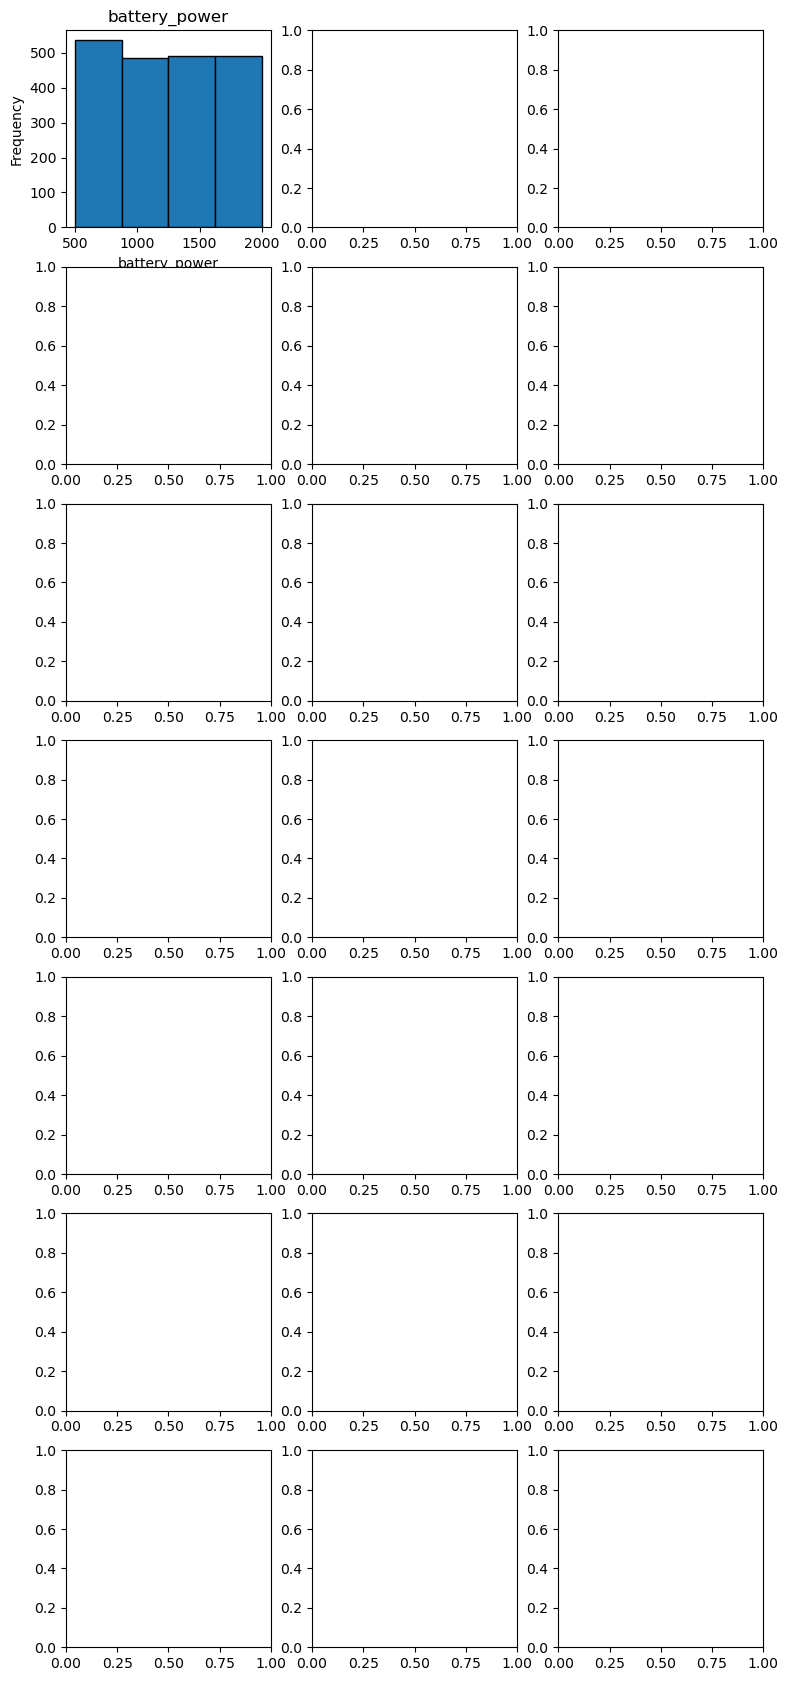

In [ ]:
util_plot.plot_df_histograms(df_raw)

### Correlation between data

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.

- fc and pc: correlation between front camera and primary camera is 0.64. The two features are independent, however the trend 

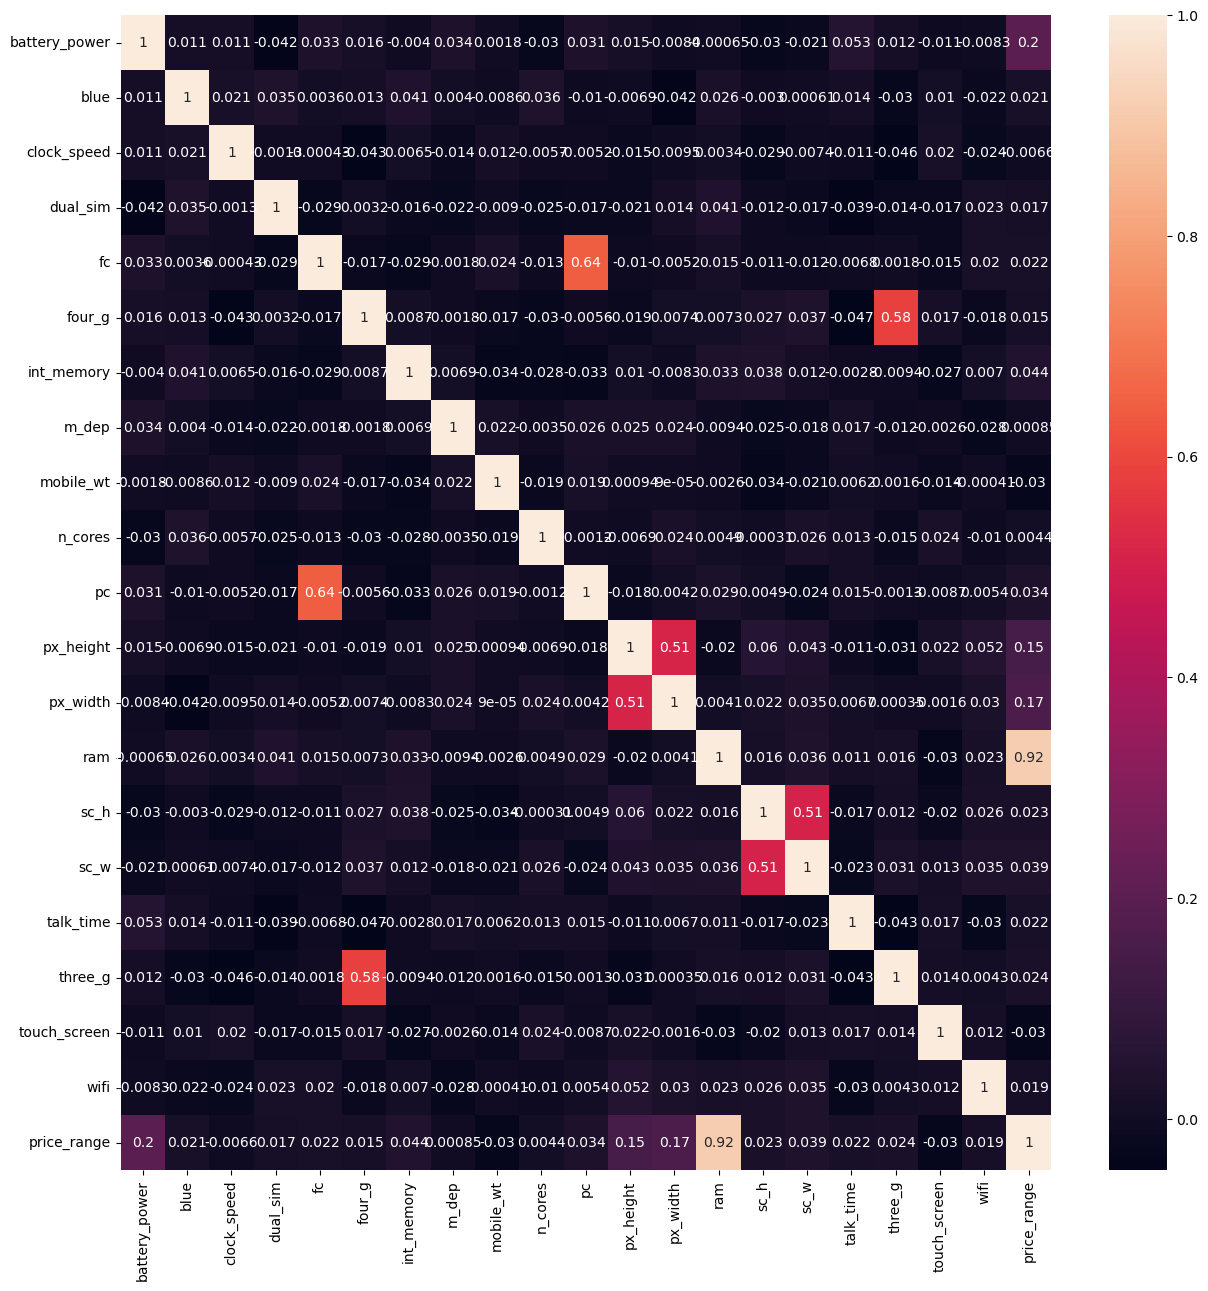

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_raw.corr(), annot=True)
plt.show()

FC and PC scatterplot

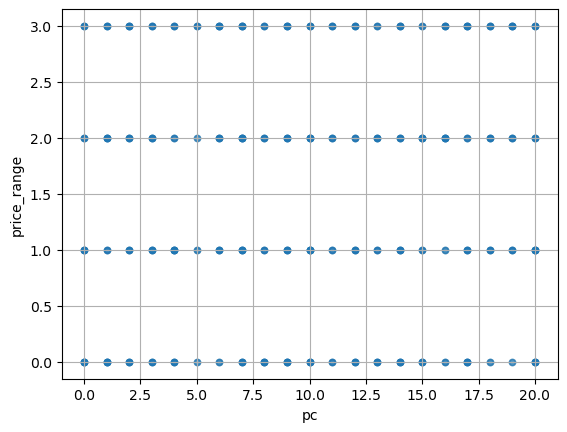

In [ ]:
df_raw.plot(kind="scatter", x="pc", y="price_range", grid=True, alpha=0.1)
plt.show()

three_g and four_g scatterplot

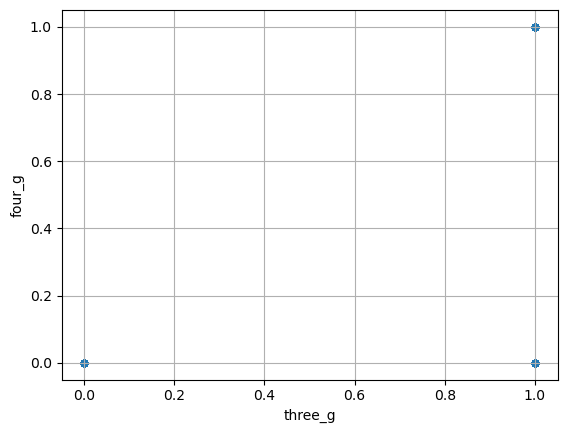

In [ ]:
df_raw.plot(kind="scatter", x="three_g", y="four_g", grid=True)
plt.show()

sc_w and sc_h scatterplot

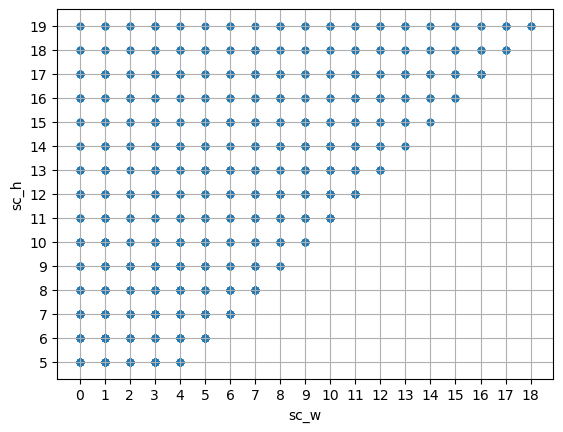

In [ ]:
# change y axis ticks to be unitary
df_raw.plot(kind="scatter", x="sc_w", y="sc_h", grid=True)
plt.yticks(np.arange(df_raw.sc_h.min(), df_raw.sc_h.max() + 1, 1.0))
plt.xticks(np.arange(df_raw.sc_w.min(), df_raw.sc_w.max() + 1, 1.0))
plt.show()

pixel_h and sc_h scatterplot

<Axes: xlabel='px_height', ylabel='sc_h'>

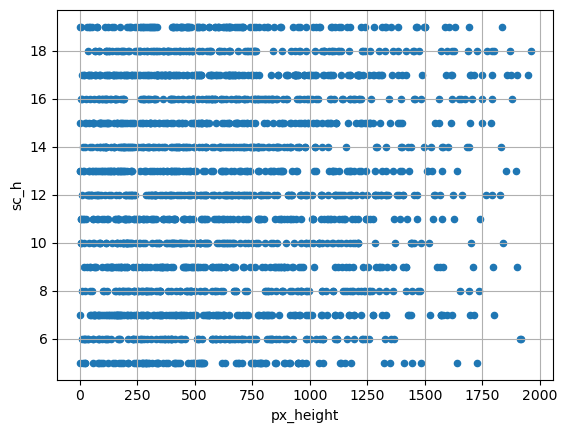

In [ ]:
df_raw.plot(kind="scatter", x="px_height", y="sc_h", grid=True)

It seems that only the ram is strongly correlated with the target variable and the other variables are not related with each other, they may have a non-linear relationship but it doesn't appear even if tested with 'kendall' coefficient.

Print some information about the features to understand the range of values covered by them and other hints.

In [ ]:
df_raw.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


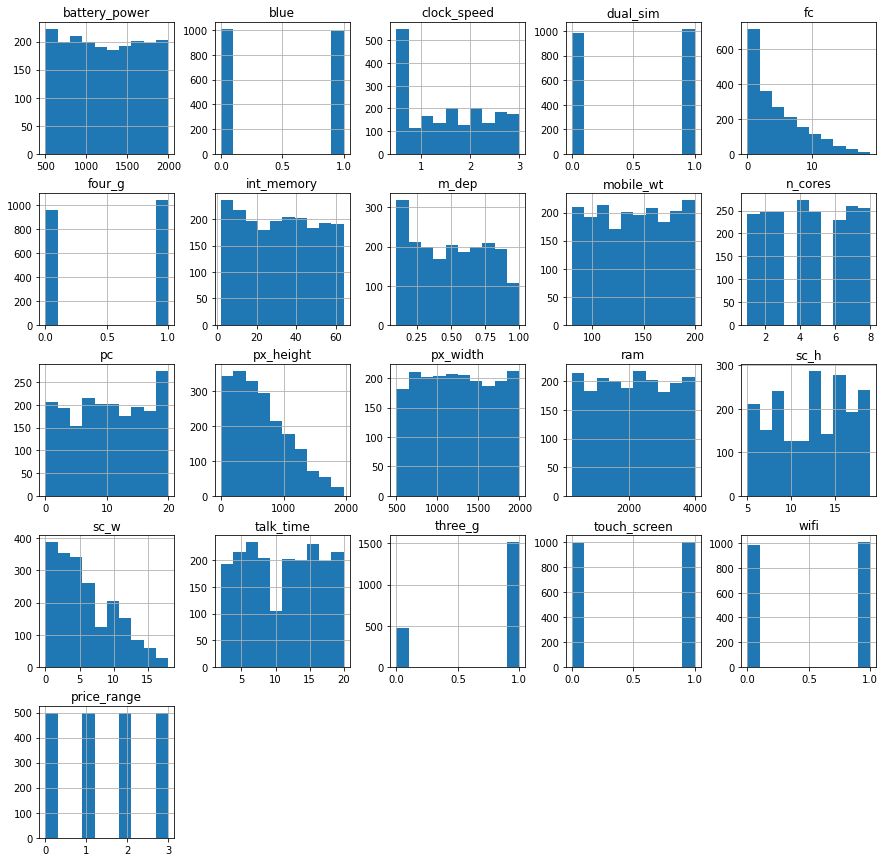

In [ ]:
df_raw.hist(figsize=(15,15));

From the histograms we can see that the number of samples for each different price range is the same, therefore we don't have imbalance.

### Split the data and normalize

We decided to split the data in with a ratio of 90/10 because of the limited number of samples and we don't care much about the performance of models on the test set but we want to evaluate the counterfactuals.

In [ ]:
df_train, df_test = util_data.split_train_test(df_raw, 0.1, SEED)

Before the split the different price ranges (target feature) were equally distributed, let's examine if the split has changed the distribution.

In [ ]:
print("The distribution of the labels of the training set after the split:")
util_data.count_frequency_labels(df_train.price_range)

The distribution of the labels of the training set after the split:


,Frequency,Count
2,25.28%,455
3,25.17%,453
1,25.06%,451
0,24.50%,441


In [ ]:
print("The distribution of the labels of the test set after the split:")
util_data.count_frequency_labels(df_test.price_range)

The distribution of the labels of the test set after the split:


,Frequency,Count
0,29.50%,59
1,24.50%,49
3,23.50%,47
2,22.50%,45


Relatively to the test set we can see that the labels are not equally likely anymore but it shouldn't affect too much our future experiments.

At this point we need to normalize our data in order to make the models work better.

In [ ]:
X_train, y_train, std_scaler, label_bin = util_data.encode_normalize_df(df_train, target="price_range")
X_test, y_test, _, _ = util_data.encode_normalize_df(df_test, target="price_range", 
                                                     std_scaler=std_scaler, label_bin=label_bin)

We can also compute the importance of each feature to predict the target variable using the RandomForestRegressor and fitting on the data.
We will use the normalized version of the data to avoid huge differences in the range of values. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=700, random_state=42)
rf.fit(X_train, y_train)

# Compute feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 13 (0.622424)
2. feature 0 (0.131013)
3. feature 11 (0.089206)
4. feature 12 (0.076927)
5. feature 8 (0.013907)
6. feature 6 (0.010032)
7. feature 16 (0.007040)
8. feature 15 (0.006796)
9. feature 7 (0.006637)
10. feature 10 (0.006536)
11. feature 14 (0.006381)
12. feature 4 (0.005644)
13. feature 2 (0.005552)
14. feature 9 (0.005182)
15. feature 3 (0.001421)
16. feature 5 (0.001236)
17. feature 17 (0.001166)
18. feature 19 (0.001015)
19. feature 1 (0.000947)
20. feature 18 (0.000937)


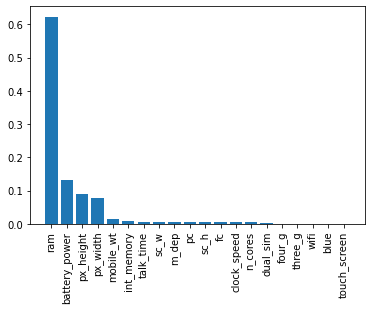

In [ ]:
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), df_train.columns[indices], rotation=90)
plt.show()

As we have already observed in the correlation matrix, the most important feature seems to be 'ram' and some feature are not actually useful for predicting the price range.

## Models and training

We will consider different models in order to test which one works better with this dataset.